This notebook provides an end-to-end example of evaluating and comparing object detection models. It demonstrates velour's ability to use business logic to define metadata, by which metrics can stratified/filtered.


We will work through a self-driving car example, where we evaluate model performance on detecting persons in and out of the road. For the dataset we will use Berkeley Deep Drive (https://bdd-data.berkeley.edu/) and we will evaluate against some pretrained torchvision detection models (https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection).

In [23]:
import json
import os
from pathlib import Path

import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

from velour.enums import TaskType
from velour import Annotation, Datum, Dataset, Model, GroundTruth, Label, Client, Prediction, viz
from velour.schemas import BoundingBox, Point, Raster, BasicPolygon

In [215]:
# make sure the BDD files are in these relative locations (or change the paths below)
imgs_path = Path("bdd100k/images/10k/val/")
masks_path = Path("bdd100k/labels/pan_seg/bitmasks/val/")

Below we define some helper functions for working with the BDD dataset. See the official BDD documentation for more info: https://doc.bdd100k.com/format.html#segmentation-formats

## Helper methods

In [40]:
def load_image(fname: str) -> Image.Image:
    return Image.open(imgs_path / fname)


def load_mask_array(fname: str) -> np.ndarray:
    """ Takes in the filename of an image and returns the mask array.
    this is an integer array of shape [H, W, 4] that encodes the classes and instance
    ids 
    """
    return np.array(Image.open(masks_path / (fname[:-3] + "png")))


def get_road_binary_mask(mask: np.ndarray) -> np.ndarray:
    """ Returns a binary array of shape [H, W] of which pixels correspond to roads
    """
    # the first channel of the mask is the category, which is 7 for roads
    return mask[:, :, 0] == 7


def get_person_instances_mask(mask: np.ndarray) -> np.ndarray:
    """ Returns an integer array of shape [H, W] where the non-zero values are pixels
    corresponding to people and the value is the instance id (unique to each different person
    in the image)
    """
    # category int for person is 31, and the last channel corresponds to instance id
    return (mask[:, :, 0] == 31) * mask[:, :, 3]


def person_is_in_road(person_bbox: BoundingBox, road_binary_mask: np.ndarray) -> bool:
    """ Determines if a person is in a road or not by checking if there are road
    pixels immediately to the left and immediately to the right of the bottom of the
    bounding box
    """
    # determine if person and road intersect sufficiently much
    road_on_left, road_on_right = False, False
    btm_y = min(int(person_bbox.ymax), road_binary_mask.shape[0] - 1)
    for offset in range(1, 5):
        if road_binary_mask[btm_y, max(int(person_bbox.xmin) - offset, 0)]:
            road_on_left = True
        if road_binary_mask[btm_y, min(int(person_bbox.xmax) + offset, road_binary_mask.shape[1] - 1)]:
            road_on_right = True

    return road_on_left and road_on_right


def get_person_bboxes(person_instances_mask: np.ndarray) -> list[BoundingBox]:
    """ From the integer mask of person instance ids, return a list of
    `Box` objects, representing the bounding boxes for each person.
    """
    boxes = []
    for instance_id in np.unique(person_instances_mask):
        if instance_id == 0:
            continue
        person_mask = person_instances_mask == instance_id
        ys, xs = np.where(person_mask)
        ymin, xmin, ymax, xmax = min(ys), min(xs), max(ys), max(xs)

        if ymin != ymax and xmin != xmax:
            boxes.append(BoundingBox.from_extrema(xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax))
    
    return boxes

## Example image

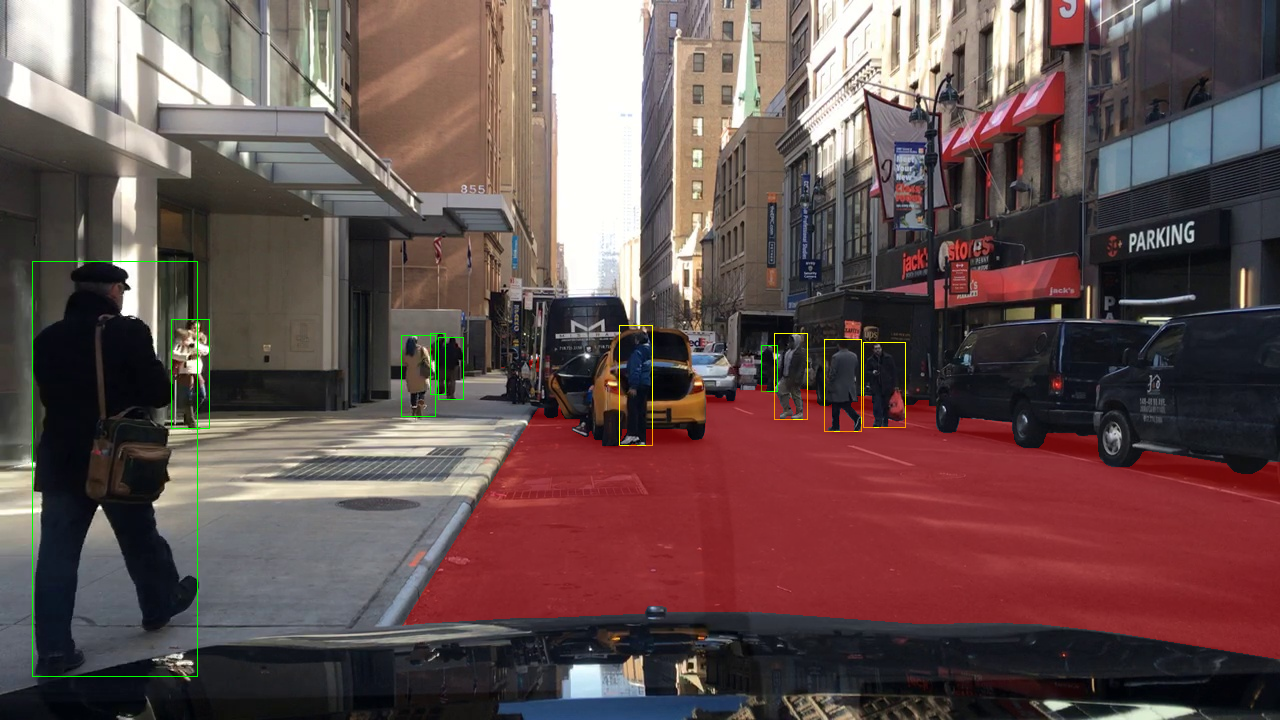

In [9]:
fname = "9b970e47-51dde695.jpg"

img = load_image(fname)
mask = load_mask_array(fname)

road_binary_mask = get_road_binary_mask(mask)
person_instances_mask = get_person_instances_mask(mask)

person_bboxes = get_person_bboxes(person_instances_mask) 
for person_bbox in person_bboxes:
    if person_is_in_road(person_bbox, road_binary_mask):
        color = (255, 255, 0)
    else:
        color = (0, 255, 0)

    # img = person_bbox.draw_on_image(img, color=color)
    img = viz.draw_bounding_box_on_image(person_bbox, img=img, color=color)

road_raster = Raster.from_numpy(road_binary_mask)
img = viz.draw_raster_on_image(road_raster, img)

display(img)

## Create the velour dataset

Here we assume that the velour service is running on `http://localhost:8000`. See https://striveworks.github.io/velour/getting_started/ for how set up the velour service.

In [10]:
client = Client("http://localhost:8000")

Successfully connected to host at http://localhost:8000/


In [11]:
dset = Dataset(client, name="bdd10k-people-in-roads")

Now we itereate through the images in the dataset and create groundtruth. We store the information of whether or not a bounding box is in the road as *metadata*, in the `"in_road"`. This demonstrates velour's ability to incorporate custom defined business logic to evaluate against (the besoke definition of `"in_road"`). 

In [13]:
for fname in tqdm(os.listdir(imgs_path)):
    datum = Datum(uid=fname)
    
    mask = load_mask_array(fname)
    
    road_binary_mask = get_road_binary_mask(mask)
    person_instances_mask = get_person_instances_mask(mask)
    
    person_bboxes = get_person_bboxes(person_instances_mask)
    
    if len(person_bboxes) == 0:
        continue
    
    annotations = [
        Annotation(
            task_type=TaskType.DETECTION,
            bounding_box=person_bbox,
            labels=[Label(key="class", value="person")],
            metadata={"in_road": person_is_in_road(person_bbox, road_binary_mask)}
        )
        for person_bbox in person_bboxes
    ]
    
    gt = GroundTruth(datum=datum, annotations=annotations)
    dset.add_groundtruth(gt)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
datums = dset.get_datums()

In [13]:
datum = datums[0]

In [14]:
datum.uid

'a933bbf8-174d4128.jpg'

In [25]:
dset.finalize()

<Response [200]>

## Run inference

In [125]:
import torch
from torchvision.transforms.functional import to_tensor
from torchvision.models.detection import (
    retinanet_resnet50_fpn_v2,
    RetinaNet_ResNet50_FPN_V2_Weights,
    fcos_resnet50_fpn,
    FCOS_ResNet50_FPN_Weights,
    fasterrcnn_mobilenet_v3_large_fpn
)

In [126]:
# set the device to GPU if available, otherwise cpu
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

retinanet = retinanet_resnet50_fpn_v2(weights=RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1).to(device).eval()
fcos = fcos_resnet50_fpn(weights=FCOS_ResNet50_FPN_Weights.COCO_V1).to(device).eval()

In [70]:
@torch.no_grad
def detect_people_on_image(net: torch.nn.Module, fname: str, score_thres: float=0.2) -> tuple[list[BoundingBox], list[float]]:
    img = load_image(fname)
    img_tensor = to_tensor(img).unsqueeze(0).to(device)
    out = net(img_tensor)[0]
    
    score_mask = out["scores"] > score_thres
    # filter out only person detections (those have label 1)
    label_mask = out["labels"] == 1
    
    bounding_boxes = [
        BoundingBox.from_extrema(xmin=box[0], ymin=box[1], xmax=box[2], ymax=box[3])
        for box in out["boxes"][score_mask & label_mask].tolist()
    ]
    scores = out["scores"][score_mask & label_mask].tolist()
    
    return bounding_boxes, scores

## Example inference

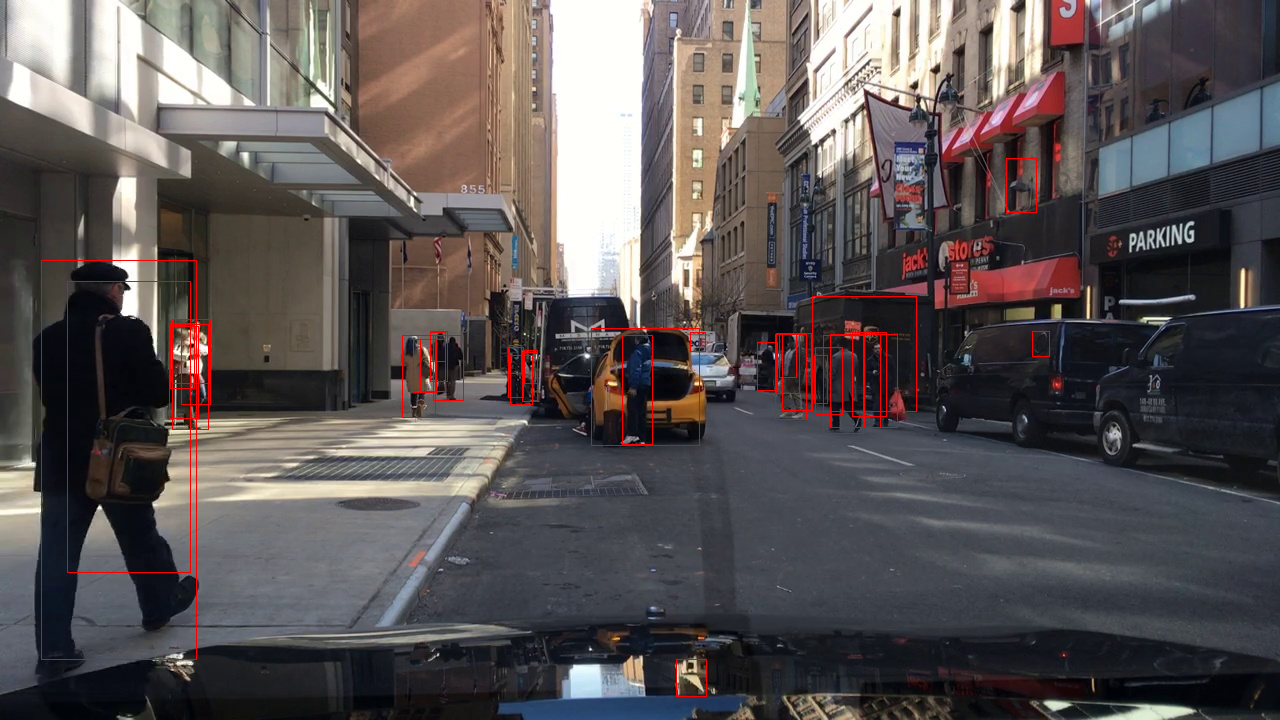

In [71]:
fname = "9b970e47-51dde695.jpg"
person_bboxes, _ = detect_people_on_image(retinanet, fname)

img = load_image(fname)
for person_bbox in person_bboxes:
    img = viz.draw_bounding_box_on_image(person_bbox, img)

display(img)

## Create the velour models, add predictions, and evaluate

In [205]:
def add_predictions(velour_model: Model, torch_model: torch.nn.Module):
    for datum in tqdm(dset.get_datums()):
        fname = datum.uid

        mask = load_mask_array(fname)

        road_binary_mask = get_road_binary_mask(mask)

        person_bboxes, scores = detect_people_on_image(torch_model, datum.uid)

        annotations = [
            Annotation(
                task_type=TaskType.DETECTION,
                bounding_box=person_bbox,
                labels=[Label(key="class", value="person", score=score)],
                metadata={"in_road": person_is_in_road(person_bbox, road_binary_mask)}
            )
            for person_bbox, score in zip(person_bboxes, scores)
        ]

        pred = Prediction(datum=datum, annotations=annotations)

        velour_model.add_prediction(dset, pred)
    velour_model.finalize_inferences(dset)


def evaluate(velour_model: Model) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    reg_eval = velour_model.evaluate_detection(dset).wait_for_completion().to_dataframe()
    in_road_eval = velour_model.evaluate_detection(dset, filters=[Annotation.metadata["in_road"] == True]).wait_for_completion().to_dataframe()
    
    
    return reg_eval, in_road_eval

In [206]:
ap_ave_over_ious = {}

for model_name, net in [("fcos_resnet50_fpn", fcos), ("retinanet_resnet50_fpn_v2", retinanet)]:
    
    model = Model(client, model_name)
    add_predictions(model, net)
    
    reg_eval, in_road_eval, out_of_road_eval = evaluate(model)
    
    print(f"Full evaluation reports for {model_name}")
    
    print("\nTotal evaluation")
    print("-----------------")
    print(reg_eval)

    print("\n\nEvaluation on people in road")
    print("-----------------------------")
    print(in_road_eval)
    
    print("\n\n\n")
    
    ap_ave_over_ious[model_name] = {
        "total": reg_eval.loc["APAveragedOverIOUs"].value[dset.name].item(),
        "in_road": in_road_eval.loc["APAveragedOverIOUs"].value[dset.name].item(),
        "out_of_road": out_of_road_eval.loc["APAveragedOverIOUs"].value[dset.name].item()
    }

  0%|          | 0/379 [00:00<?, ?it/s]

Full evaluation report for fcos_resnet50_fpn

Total evaluation
-----------------
                                                                                                      value
dataset                                                                              bdd10k-people-in-roads
type                parameters                                         label                               
AP                  {"iou": 0.5}                                       class: person               0.511829
                    {"iou": 0.75}                                      class: person               0.297618
APAveragedOverIOUs  {"ious": [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8,... class: person               0.297068
mAP                 {"iou": 0.5}                                       n/a                         0.511829
                    {"iou": 0.75}                                      n/a                         0.297618
mAPAveragedOverIOUs {"ious": [0.5, 0.55, 0.6, 0.7, 0.65

  0%|          | 0/379 [00:00<?, ?it/s]

/Users/eric/repos/velour/client/velour/coretypes.py:1061: UserWarning: Prediction for datum with uid `8e437e6c-b40fad7d.jpg` contains no annotations.
  warnings.warn(
/Users/eric/repos/velour/client/velour/coretypes.py:1061: UserWarning: Prediction for datum with uid `a2ae40f3-00000000.jpg` contains no annotations.
  warnings.warn(
/Users/eric/repos/velour/client/velour/coretypes.py:1061: UserWarning: Prediction for datum with uid `a91b7555-00001085.jpg` contains no annotations.
  warnings.warn(
/Users/eric/repos/velour/client/velour/coretypes.py:1061: UserWarning: Prediction for datum with uid `a91b7555-00001250.jpg` contains no annotations.
  warnings.warn(
/Users/eric/repos/velour/client/velour/coretypes.py:1061: UserWarning: Prediction for datum with uid `a00d3a96-00000000.jpg` contains no annotations.
  warnings.warn(
/Users/eric/repos/velour/client/velour/coretypes.py:1061: UserWarning: Prediction for datum with uid `8119e56e-00000000.jpg` contains no annotations.
  warnings.warn

Full evaluation report for retinanet_resnet50_fpn_v2

Total evaluation
-----------------
                                                                                                      value
dataset                                                                              bdd10k-people-in-roads
type                parameters                                         label                               
AP                  {"iou": 0.5}                                       class: person               0.503219
                    {"iou": 0.75}                                      class: person               0.311630
APAveragedOverIOUs  {"ious": [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8,... class: person               0.294759
mAP                 {"iou": 0.5}                                       n/a                         0.503219
                    {"iou": 0.75}                                      n/a                         0.311630
mAPAveragedOverIOUs {"ious": [0.5, 0.55, 0.6, 0

We now focus on the aggregate metrics `APAveragedOverIOUs`. From the table below we see that score for detecting people overall is very close between the two models (with a slight advantange to `fcos_resnet50_fpn`). However, if we are more concerned with being able to detect people in roads, then the model `retinanet_resnet50_fpn_v2` is clearly the better choice. 

In [212]:
pd.DataFrame(ap_ave_over_ious)

,fcos_resnet50_fpn,retinanet_resnet50_fpn_v2
total,0.297068,0.294759
in_road,0.394137,0.421248
